In [60]:
%matplotlib inline

import pandas as pd
from sklearn.metrics import auc
import matplotlib.pyplot as plt # standard Python plotting library
import numpy as np  # fundamental package for scientific computing, handles arrays and math
import scipy.signal
from scipy.signal import find_peaks, peak_prominences
import scipy.stats as stats
from scipy.stats import zscore
from pathlib import Path
import tdt # import the tdt library
import seaborn as sns
from matplotlib import rcParams
import os
import numpy as np
import glob

In [61]:
isosbestic = '_415A'
dopa='_465A'
CHANNEL = 1
TRANGE       = [-5, 10]
BASELINE_PER = [-5, 2]
event_type = 'RNP_'
event_type2 = 'UnNP'

def read_filesEPOC1(path): 
    
    blockpath = path
    data = tdt.read_block(blockpath, evtype=['epocs','streams'], channel=CHANNEL)
    data = tdt.epoc_filter(data, event_type, t=TRANGE)  #filters the chosen epocs (EPOC1_) and time set around those epocs
    # More examples of list comprehensions
    min1 = np.min([np.size(x) for x in data['streams'][dopa].filtered])
    min2 = np.min([np.size(x) for x in data['streams'][isosbestic].filtered])
    data['streams'][dopa].filtered = [x[1:min1] for x in data['streams'][dopa].filtered]
    data['streams'][isosbestic].filtered = [x[1:min2] for x in data['streams'][isosbestic].filtered]

    # Downsample and average 10x via a moving window mean
    N = 10 # Average every 10 samples into 1 value
    F415 = []
    F465 = []
    for lst in data['streams'][isosbestic].filtered: 
        small_lst = []
        for i in range(0, min2, N):
            small_lst.append(np.mean(lst[i:i+N-1])) # This is the moving window mean
        F415.append(small_lst)

    for lst in data['streams'][dopa].filtered: 
        small_lst = []
        for i in range(0, min1, N):
            small_lst.append(np.mean(lst[i:i+N-1]))
        F465.append(small_lst)

    #Create a mean signal, standard error of signal, and DC offset
    meanF415 = np.mean(F415, axis=0)
    stdF415 = np.std(F415, axis=0)/np.sqrt(len(data['streams'][isosbestic].filtered))
    dcF415 = np.mean(meanF415)
    meanF465 = np.mean(F465, axis=0)
    stdF465 = np.std(F465, axis=0)/np.sqrt(len(data['streams'][dopa].filtered))
    dcF465 = np.mean(meanF465)
    Y_fit_all = []
    Y_dF_all = []
    for x, y in zip(F415, F465):
        x = np.array(x)
        y = np.array(y)
        bls = np.polyfit(x, y, 1)
        fit_line = np.multiply(bls[0], x) + bls[1]
        Y_fit_all.append(fit_line)
        Y_dF_all.append(y-fit_line)
    EPOC1_ts1 = TRANGE[0] + np.linspace(1, len(meanF465), len(meanF465))/data['streams'][dopa].fs*N
    EPOC1_ts2 = TRANGE[0] + np.linspace(1, len(meanF415), len(meanF415))/data['streams'][isosbestic].fs*N

    # Getting the z-score and standard error
    EPOC1_zall = []
    for dF in Y_dF_all: 
        ind = np.where((np.array(EPOC1_ts2)<BASELINE_PER[1]) & (np.array(EPOC1_ts2)>BASELINE_PER[0]))
        zb = np.mean(dF[ind])
        zsd = np.std(dF[ind])
        EPOC1_zall.append((dF - zb)/zsd)
    EPOC1_ts1 = TRANGE[0] + np.linspace(1, len(meanF465), len(meanF465))/data['streams'][dopa].fs*N
    EPOC1_ts2 = TRANGE[0] + np.linspace(1, len(meanF415), len(meanF415))/data['streams'][isosbestic].fs*N
    # ts3 = TRANGE[2] + np.linspace(1, len(meanF415), len(meanF415))/data['streams'][isosbestic].fs*N
    
    EPOC1_zerror = np.std(EPOC1_zall, axis=0)#/np.sqrt(np.size(zall, axis=0))

    return EPOC1_zall, EPOC1_ts1, EPOC1_ts2, EPOC1_zerror

def read_filesEPOC2(path): 
    
    blockpath = path
    data = tdt.read_block(blockpath, evtype=['epocs','streams'], channel=CHANNEL)
    data = tdt.epoc_filter(data, event_type2, t=TRANGE)  #filters the chosen epocs (EPOC2_) and time set around those epocs
    # More examples of list comprehensions
    min1 = np.min([np.size(x) for x in data['streams'][dopa].filtered])
    min2 = np.min([np.size(x) for x in data['streams'][isosbestic].filtered])
    data['streams'][dopa].filtered = [x[1:min1] for x in data['streams'][dopa].filtered]
    data['streams'][isosbestic].filtered = [x[1:min2] for x in data['streams'][isosbestic].filtered]

    # Downsample and average 10x via a moving window mean
    N = 10 # Average every 10 samples into 1 value
    F415 = []
    F465 = []
    for lst in data['streams'][isosbestic].filtered: 
        small_lst = []
        for i in range(0, min2, N):
            small_lst.append(np.mean(lst[i:i+N-1])) # This is the moving window mean
        F415.append(small_lst)

    for lst in data['streams'][dopa].filtered: 
        small_lst = []
        for i in range(0, min1, N):
            small_lst.append(np.mean(lst[i:i+N-1]))
        F465.append(small_lst)

    #Create a mean signal, standard error of signal, and DC offset
    meanF415 = np.mean(F415, axis=0)
    stdF415 = np.std(F415, axis=0)/np.sqrt(len(data['streams'][isosbestic].filtered))
    dcF415 = np.mean(meanF415)
    meanF465 = np.mean(F465, axis=0)
    stdF465 = np.std(F465, axis=0)/np.sqrt(len(data['streams'][dopa].filtered))
    dcF465 = np.mean(meanF465)
    Y_fit_all = []
    Y_dF_all = []
    for x, y in zip(F415, F465):
        x = np.array(x)
        y = np.array(y)
        bls = np.polyfit(x, y, 1)
        fit_line = np.multiply(bls[0], x) + bls[1]
        Y_fit_all.append(fit_line)
        Y_dF_all.append(y-fit_line)
    EPOC2_ts1 = TRANGE[0] + np.linspace(1, len(meanF465), len(meanF465))/data['streams'][dopa].fs*N
    EPOC2_ts2 = TRANGE[0] + np.linspace(1, len(meanF415), len(meanF415))/data['streams'][isosbestic].fs*N

    # Getting the z-score and standard error
    EPOC2_zall = []
    for dF in Y_dF_all: 
        ind = np.where((np.array(EPOC2_ts2)<BASELINE_PER[1]) & (np.array(EPOC2_ts2)>BASELINE_PER[0]))
        zb = np.mean(dF[ind])
        zsd = np.std(dF[ind])
        EPOC2_zall.append((dF - zb)/zsd)
    EPOC2_ts1 = TRANGE[0] + np.linspace(1, len(meanF465), len(meanF465))/data['streams'][dopa].fs*N
    EPOC2_ts2 = TRANGE[0] + np.linspace(1, len(meanF415), len(meanF415))/data['streams'][isosbestic].fs*N
    # ts3 = TRANGE[2] + np.linspace(1, len(meanF415), len(meanF415))/data['streams'][isosbestic].fs*N
    
    EPOC2_zerror = np.std(EPOC2_zall, axis=0)#/np.sqrt(np.size(zall, axis=0))

    return EPOC2_zall, EPOC2_ts1, EPOC2_ts2, EPOC2_zerror



In [62]:
EPOC1_h_zavg = [] #het zscore average 
EPOC1_h_zste = [] # het zscore standard error
EPOC1_h_ts1 = []
EPOC1_h_ts2 = []

EPOC2_h_zavg = [] #EPOC2 zscore average 
EPOC2_h_zste = [] # EPOC2 zscore standard error
EPOC2_h_ts1 = []
EPOC2_h_ts2 = []

for file in glob.glob(r"N:\2024April_May_Tanks_GRBDA_RI\Day16_RI60_05092024\HET/*"): # het
    EPOC1_z_ind = read_filesEPOC1(file)
    EPOC1_h_zavg.extend(EPOC1_z_ind[0])
    EPOC1_h_ts1 = EPOC1_z_ind[1]
    EPOC1_h_ts2 = EPOC1_z_ind[2]
    EPOC1_h_zste.append(EPOC1_z_ind[3])

    EPOC2_z_ind = read_filesEPOC2(file)
    EPOC2_h_zavg.extend(EPOC2_z_ind[0])
    EPOC2_h_ts1 = EPOC2_z_ind[1]
    EPOC2_h_ts2 = EPOC2_z_ind[2]
    EPOC2_h_zste.append(EPOC2_z_ind[3])

print(f"total number EPOC1: {len(EPOC1_h_zavg)}")
print(f"total number EPOC2: {len(EPOC2_h_zavg)}")

read from t=0s to t=3599.15s
read from t=0s to t=3599.15s
total number EPOC1: 46
total number EPOC2: 2245


In [63]:
EPOC1_h_zavg_eventwise=(np.array(EPOC1_h_zavg).mean(axis=0))
EPOC1_h_zste_eventwise=(np.array(EPOC1_h_zavg).std(axis=0))

print(len(EPOC1_h_zste_eventwise))
auc(EPOC1_h_ts1, EPOC1_h_zavg_eventwise)
# one_event_het_avg = np.mean([h_zavg], axis=0)
# (one_event_het_avg)

EPOC2_h_zavg_eventwise=(np.array(EPOC2_h_zavg).mean(axis=0))
EPOC2_h_zste_eventwise=(np.array(EPOC2_h_zavg).std(axis=0))

print(len(EPOC2_h_zste_eventwise))
auc(EPOC2_h_ts1, EPOC2_h_zavg_eventwise)
# one_event_het_avg = np.mean([h_zavg], axis=0)
# (one_event_het_avg)

1018
1018


0.11767948972581112

In [64]:
EPOC1_w_zavg = []
EPOC1_w_zste = []
EPOC1_w_ts1 = []
EPOC1_w_ts2 = []
EPOC1_w_ind_z = []

EPOC2_w_zavg = []
EPOC2_w_zste = []
EPOC2_w_ts1 = []
EPOC2_w_ts2 = []
EPOC2_w_ind_z = []

for file in glob.glob(r"N:\2024April_May_Tanks_GRBDA_RI\Day16_RI60_05092024\WTY/*"): # wild type
    EPOC1_z_ind = read_filesEPOC1(file)
    EPOC1_w_zavg.extend(EPOC1_z_ind[0])
    EPOC1_w_ts1 = EPOC1_z_ind[1]
    EPOC1_w_ts2 = EPOC1_z_ind[2]
    EPOC1_w_zste.append(EPOC1_z_ind[3])

    EPOC2_z_ind = read_filesEPOC2(file)
    EPOC2_w_zavg.extend(EPOC2_z_ind[0])
    EPOC2_w_ts1 = EPOC2_z_ind[1]
    EPOC2_w_ts2 = EPOC2_z_ind[2]
    EPOC2_w_zste.append(EPOC2_z_ind[3])

print(f"total number events: {len(EPOC1_w_zavg)}")
print(f"total number events: {len(EPOC2_w_zavg)}")

read from t=0s to t=3599.04s
read from t=0s to t=3599.04s
total number events: 34
total number events: 1797


In [65]:
EPOC1_w_zavg_eventwise=(np.array(EPOC1_w_zavg).mean(axis=0)) 
EPOC1_w_zste_eventwise=np.array(EPOC1_w_zavg).std(axis=0)

EPOC2_w_zavg_eventwise=(np.array(EPOC2_w_zavg).mean(axis=0)) 
EPOC2_w_zste_eventwise=np.array(EPOC2_w_zavg).std(axis=0)

# average hets and wildtypes to one zscore array in a t second period of event
print(auc(EPOC1_w_ts1, EPOC1_w_zavg_eventwise), auc(EPOC2_w_ts1, EPOC2_w_zavg_eventwise), auc(EPOC1_h_ts1, EPOC1_h_zavg_eventwise), auc(EPOC2_h_ts1, EPOC2_h_zavg_eventwise))

-0.4992863476130549 0.3338245777269872 0.06073320159371631 0.11767948972581112


In [66]:
# auc_list_w = []
# ts3 = []
# w_new_z_array = []
# w_cropped_for_auc = []
# for i in range(len(w_ind_z)):
#     w_new_z_array.append(np.mean(w_ind_z[i], axis = 0))

# for i in range(len(w_new_z_array)):
#     w_time_cropped_z = []
#     for j in range(len(ts2)):
#         if (ts2[j] < 2) & (ts2[j] > 0): # start and end time values
#             ts3.append(ts2[j])
#             w_time_cropped_z.append(w_new_z_array[i][j])
#     w_cropped_for_auc.append(w_time_cropped_z)

# print(len(ts3))
# for i in range(len(w_cropped_for_auc)):
#     auc_list_w.append(auc((ts3/(i+1)),w_cropped_for_auc[i]))
# print(auc_list_w)
    
    

In [67]:
# mean_zste = []
# # mean_zste = np.mean([zste[0],zste[1]], axis = 0)
# for i in range(len(zste[0])):
#     sigma = np.sqrt(((zste[0][i]**2)/len(zste[0]))+((zste[1][i]**2)/len(zste[1])))
#     mean_zste.append(sigma)
# mean_zste
 

In [68]:
np.array(EPOC1_h_zavg)
EPOC1_h_zerror = np.std(EPOC1_h_zavg, axis=0)/np.sqrt(np.size(EPOC1_h_zavg, axis=0))
np.array(EPOC2_h_zavg)
EPOC2_h_zerror = np.std(EPOC2_h_zavg, axis=0)/np.sqrt(np.size(EPOC2_h_zavg, axis=0))

np.array(EPOC1_w_zavg)
EPOC1_w_zerror = np.std(EPOC1_w_zavg, axis=0)/np.sqrt(np.size(EPOC1_w_zavg, axis=0))
np.array(EPOC2_w_zavg)
EPOC2_w_zerror = np.std(EPOC2_w_zavg, axis=0)/np.sqrt(np.size(EPOC2_w_zavg, axis=0))


In [69]:
# stats.sem(h_zavg)

In [70]:
# from scipy.signal import find_peaks, peak_prominences, peak_widths


In [71]:
# peaks = find_peaks(np.mean(w_zavg, axis=0), prominence=1)
# peaks_y = [np.mean(w_zavg, axis=0)[i] for i in peaks[0]]

In [72]:
# peaks[0]-widths[2]

In [73]:
# widths = peak_widths(np.mean(w_zavg, axis=0), peaks[0])
# widths

In [74]:
# prominence = peak_prominences(np.mean(w_zavg, axis=0) ,peaks[0])
# prominence # how to do stats if we're calculating the genotype averages

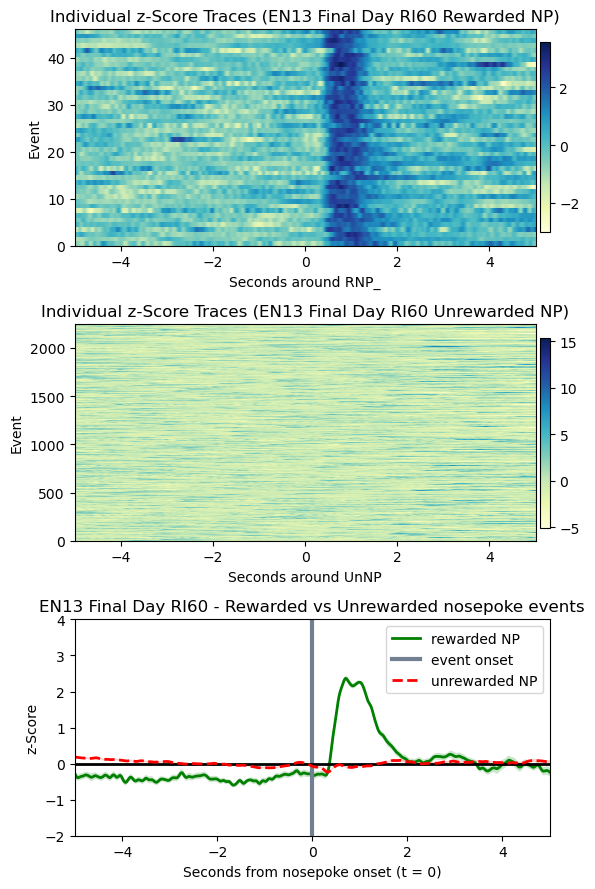

In [75]:
fig = plt.figure(figsize=(6, 9))
ax1 = fig.add_subplot(311) # HET EPOC1
cs = ax1.imshow(EPOC1_h_zavg, cmap=plt.cm.YlGnBu, interpolation='none', aspect="auto",
                extent=[TRANGE[0], TRANGE[1]+TRANGE[0], 0, len(EPOC1_h_zavg)])
cbar = fig.colorbar(cs, pad=0.01, fraction=0.02)

ax1.set_title('Individual z-Score Traces (EN13 Final Day RI60 Rewarded NP)')
ax1.set_ylabel('Event')
ax1.set_xlabel(f'Seconds around {event_type}')

plt.close() # Suppress figure output again

ax3 = fig.add_subplot(312) # HET EPOC2
cs3 = ax3.imshow(EPOC2_h_zavg, cmap=plt.cm.YlGnBu, interpolation='none', aspect="auto",
                extent=[TRANGE[0], TRANGE[1]+TRANGE[0], 0, len(EPOC2_h_zavg)])
cbar3 = fig.colorbar(cs3, pad=0.01, fraction=0.02)
ax3.set_title('Individual z-Score Traces (EN13 Final Day RI60 Unrewarded NP)')
ax3.set_ylabel('Event')
ax3.set_xlabel(f'Seconds around {event_type2}')
plt.close()

ax2 = fig.add_subplot(313) # HET EPOC1 vs EPOC2 signal flow plot
p6 = ax2.plot(EPOC1_h_ts2, np.mean(EPOC1_h_zavg, axis=0), linewidth=2, color='green', label='rewarded NP')
p7 = ax2.fill_between(EPOC1_h_ts1, np.mean(EPOC1_h_zavg, axis=0)+EPOC1_h_zerror
                      ,np.mean(EPOC1_h_zavg, axis=0)-EPOC1_h_zerror, facecolor='green', alpha=0.2)
p8 = ax2.axvline(x=0, linewidth=3, color='slategray', label=f'event onset')
p8 = ax2.axhline(y=0, linewidth=2, color='black')
ax2.set_ylim([-2, 4])
ax2.set_ylabel('z-Score')
ax2.set_xlabel('Seconds from nosepoke onset (t = 0)')
ax2.set_xlim(TRANGE[0], TRANGE[1]+TRANGE[0])
ax2.set_title('EN13 Final Day RI60 - Rewarded vs Unrewarded nosepoke events')
# ax2.scatter((peaks[0]-509)/101, peaks_y,s = 60, color="red", marker = "o")
# ax2.scatter(((peaks[0]-509)/101)+(widths[0]/2), peaks_y, s = 60, color = 'blue')
p9 = ax2.plot(EPOC2_h_ts2, np.mean(EPOC2_h_zavg, axis=0), linewidth=2, color='red', linestyle='--', label='unrewarded NP')
p10 = ax2.fill_between(EPOC2_h_ts1, np.mean(EPOC2_h_zavg, axis=0)+EPOC2_h_zerror
                      ,np.mean(EPOC2_h_zavg, axis=0)-EPOC2_h_zerror, facecolor='red', alpha=0.2)

ax2.legend()

plt.close()
fig.tight_layout()
fig
 #Graph 3
#Graph 2

In [76]:
EPOC2_w_zerror

array([0.02692002, 0.02678649, 0.0266784 , ..., 0.03275209, 0.03289356,
       0.03298625], dtype=float32)

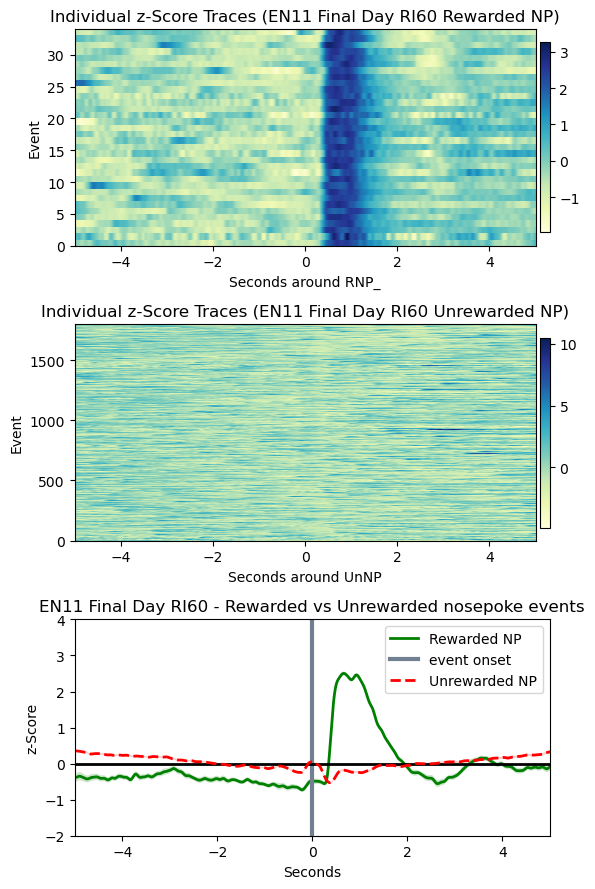

In [77]:
fig = plt.figure(figsize=(6,9))
ax1 = fig.add_subplot(311) # WT EPOC1
cs = ax1.imshow(EPOC1_w_zavg, cmap=plt.cm.YlGnBu, interpolation='none', aspect="auto",
                extent=[TRANGE[0], TRANGE[1]+TRANGE[0], 0, len(EPOC1_w_zavg)])
cbar = fig.colorbar(cs, pad=0.01, fraction=0.02)

ax1.set_title('Individual z-Score Traces (EN11 Final Day RI60 Rewarded NP)')
ax1.set_ylabel('Event')
ax1.set_xlabel(f'Seconds around {event_type}')

plt.close() # Suppress figure output again

ax3 = fig.add_subplot(312) # WT EPOC2
cs3 = ax3.imshow(EPOC2_w_zavg, cmap=plt.cm.YlGnBu, interpolation='none', aspect="auto",
                extent=[TRANGE[0], TRANGE[1]+TRANGE[0], 0, len(EPOC2_w_zavg)])
cbar3 = fig.colorbar(cs3, pad=0.01, fraction=0.02)
ax3.set_title('Individual z-Score Traces (EN11 Final Day RI60 Unrewarded NP)')
ax3.set_ylabel('Event')
ax3.set_xlabel(f'Seconds around {event_type2}')
plt.close()

ax2 = fig.add_subplot(313) # WT EPOC1 vs EPOC2 signal flow plot
p6 = ax2.plot(EPOC1_w_ts2, np.mean(EPOC1_w_zavg, axis=0), linewidth=2, color='green', label='Rewarded NP')
p7 = ax2.fill_between(EPOC1_w_ts1, np.mean(EPOC1_w_zavg, axis=0)+EPOC1_w_zerror
                      ,np.mean(EPOC1_w_zavg, axis=0)-EPOC1_w_zerror, facecolor='green', alpha=0.2)
p8 = ax2.axvline(x=0, linewidth=3, color='slategray', label=f'event onset')
p8 = ax2.axhline(y=0, linewidth=2, color='black')
ax2.set_ylim([-2, 4])
ax2.set_ylabel('z-Score')
ax2.set_xlabel('Seconds')
ax2.set_xlim(TRANGE[0], TRANGE[1]+TRANGE[0])
ax2.set_title('EN11 Final Day RI60 - Rewarded vs Unrewarded nosepoke events')
# ax2.scatter((peaks[0]-509)/101, peaks_y,s = 60, color="red", marker = "o")
# ax2.scatter(((peaks[0]-509)/101)+(widths[0]/2), peaks_y, s = 60, color = 'blue')
p9 = ax2.plot(EPOC2_w_ts2, np.mean(EPOC2_w_zavg, axis=0), linewidth=2, color='red', linestyle='--', label='Unrewarded NP')
p10 = ax2.fill_between(EPOC2_w_ts1, np.mean(EPOC2_w_zavg, axis=0)+EPOC2_w_zerror
                      ,np.mean(EPOC2_w_zavg, axis=0)-EPOC2_w_zerror, facecolor='red', alpha=0.2)

ax2.legend()

plt.close()
fig.tight_layout()
fig
 #Graph 3
#Graph 2

In [78]:
EPOC1_h_mean_zavg = np.mean(EPOC1_h_zavg, axis=0)
h_ts4 = []
EPOC1_h_trimmed_z_array = []
EPOC2_h_trimmed_z_array = []
for i in range(len(EPOC1_h_ts2)): # since EPOC1_ts and EPOC2_ts are the same
    if (EPOC1_h_ts2[i] < 2) & (EPOC1_h_ts2[i] > 0): # start and end time values
        h_ts4.append(EPOC1_h_ts2[i])
        EPOC1_h_trimmed_z_array.append(EPOC1_h_zavg_eventwise[i])
        EPOC2_h_trimmed_z_array.append(EPOC2_h_zavg_eventwise[i])


In [79]:
print(auc(h_ts4, EPOC1_h_trimmed_z_array))
print(auc(h_ts4, EPOC2_h_trimmed_z_array))
# find auc per event and then compare using mann whitney

1.9931523034413972
-0.09296895540246941


In [80]:
EPOC1_w_mean_zavg = np.mean(EPOC1_w_zavg, axis=0)
w_ts4 = []
EPOC1_w_trimmed_z_array = []
EPOC2_w_trimmed_z_array = []
for i in range(len(EPOC1_w_ts2)): # since EPOC1_ts and EPOC2_ts are the same
    if (EPOC1_w_ts2[i] < 2) & (EPOC1_w_ts2[i] > 0): # start and end time values
        w_ts4.append(EPOC1_w_ts2[i])
        EPOC1_w_trimmed_z_array.append(EPOC1_w_zavg_eventwise[i])
        EPOC2_w_trimmed_z_array.append(EPOC2_w_zavg_eventwise[i])


In [81]:
print(auc(w_ts4, EPOC1_w_trimmed_z_array))
print(auc(w_ts4, EPOC2_w_trimmed_z_array))
# find auc per event and then compare using mann whitney

2.1720307533336767
-0.35094847926719375


KstestResult(statistic=0.8137254901960784, pvalue=3.968860730192568e-68, statistic_location=0.09156339, statistic_sign=-1)

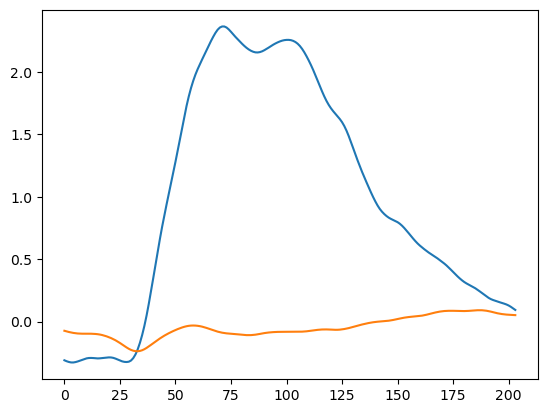

In [82]:
sns.lineplot(EPOC1_h_trimmed_z_array)
sns.lineplot(EPOC2_h_trimmed_z_array)
scipy.stats.ks_2samp(EPOC1_h_trimmed_z_array, EPOC2_h_trimmed_z_array)
# for stats, use appropriate time block (ie 0-2 s)

KstestResult(statistic=0.7794117647058824, pvalue=1.5559361632751014e-61, statistic_location=0.044441927, statistic_sign=-1)

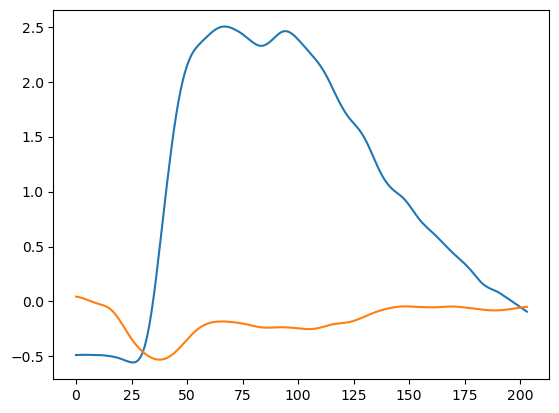

In [83]:
sns.lineplot(EPOC1_w_trimmed_z_array)
sns.lineplot(EPOC2_w_trimmed_z_array)
scipy.stats.ks_2samp(EPOC1_w_trimmed_z_array, EPOC2_w_trimmed_z_array)
# for stats, use appropriate time block (ie 0-2 s)

In [84]:
scipy.stats.mannwhitneyu(EPOC1_h_zavg_eventwise, EPOC2_h_zavg_eventwise)
scipy.stats.mannwhitneyu(EPOC1_w_zavg_eventwise, EPOC2_w_zavg_eventwise)

MannwhitneyuResult(statistic=238661.0, pvalue=1.4021554491163944e-98)

In [85]:
# spike/slope analysis

Dopamine sensor peak events were calculated using custom peak detection scripts2,49. A 10s moving window was used for thresholding, where high amplitude events (local maxima greater than two median average deviations above the median of the moving window) were removed to calculate a new baseline moving median. Peaks were defined as events with local maxima greater than 3 median average deviations above this new baseline moving median. Peak amplitude was calculated as the difference between the peak maxima and the local median.

In [86]:
#sliding window
# def sliding_window(elements, size):
#     if len(elements) <= size:
#         return elements
#     for i in range(len(elements)- size + 1):
#         yield elements[i:i+size]

In [87]:
# x = list(sliding_window(h_trimmed_z_array, 10))

In [88]:
# np.mean(h_zavg_eventwise[0:5])

In [89]:
# peaks[0]

In [90]:
# peaks_y # amplitude

In [91]:
# (np.mean(w_zavg, axis=0))[613]


In [92]:
# plt.figure(figsize=[10, 5])
# plt.plot((np.mean(w_zavg, axis=0)))
# plt.scatter(peaks[0], peaks_y,s = 60, color="red", marker = "o")
# plt.title("mice", fontsize=24)
# plt.ylabel("z score", fontsize=24)
# plt.xlabel("time", fontsize=24)

# print(peaks)
# print(len(peaks[0]))

In [93]:
# T50 = widths[0]/(4*(1018/10)) 
# T50
# assumes perfectly symmetrical peak

In [94]:
# T50_list = []
# for i in range(len(peaks[0])):
#     t50 = (peaks[0][i]-widths[2][i])/(2*101.8)
#     T50_list.append(t50)
# T50_list
# # this is currently per genotype, analyze per event and sav to list in "epoch_averaging.ipynb"